# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import time
import random
import copy
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

#### Actor-Critic Agents:

Actor-Critic agents are at the intersection of value based methods (DQN) and policy based methods such as reinforce.

These agent are more stable than value based agents and need less samples than policy based agents.

They are based on temporal difference (TD) technique so have smaller variance.

The two deep neural networks for actor and critic:

Actor:

- Fully connected
- Input size: state size 24
- Hidden layers: 2
- Hidden layers size: [164,164]
- Output size: action size: 2
- Leaky ReLU
- Batch normalization
- ReLU
- Batch normalization

Critic:

- Fully connected
- Input size: state size 24
- Hidden layers: 2
- Hidden layers size: [164+2,164]
- Output size: 1
- Leaky ReLU
- Batch normalization
- ReLU
- Batch normalization

In [11]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed=0, fc1_units=164, fc2_units=164):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        x = F.leaky_relu(self.fc1(state))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed=0, fcs1_units=164, fc2_units=164):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        xs = F.leaky_relu(self.fcs1(state))
        xs = self.bn1(xs)
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        return self.fc3(x)

In [1]:
from IPython.display import display, Math, Latex

## MADDPG

We use deep Q learning method that adopts actor-critic methods that considers action policies
of other agents and is able to successfully learn policies that require complex multiagent coordination.
In Actor-Critic Method:
- Actor: Used to approximate optimum policy deterministically $argmax_a Q(s,a)$ which mean best action. Actor maps state $S$ to $\mu (S;\theta_{\mu})$. We also add niose sample to actor output to generate more robust results.
- Critic: Learns to evaluate optimal action value function by using actros best believed action. Critic maps state $S$ to $Q(S,\mu (S;\theta_{\mu});\theta_Q)$.

In MADDPG algorithm in each episode we initialize random process $N$ for action exploration and then will recieve state $x$. Then for the length of episode first, for each agent $i$, we select action $a_i = \mu_{\theta_i}(o_i) + N_t$ w.r.t. the current policy and exploration used replay buffer and soft update to the target networks. Second, we execute actions $a = (a_1, . . . , a_N)$ and observe reward $r$ and new state $x\prime$. Third, we store $(x, a, r, x\prime)$ in replay buffer $D$ and update the state. Then, for each agent, we first sample a random minibatch of $S$ samples $(x^j, a^j, r^j, x\prime^j)$ from $D$. Second, we set $y^j= r_i^j +\gamma Q_i^\mu (x\prime^j, a\prime_1, a\prime_2, ..., a\prime_N)$ and update actor and critic networks. We update target network based on the


- Actor: $\theta^{Q\prime}=\eta \theta^Q + (1-\eta) \theta^{Q\prime}$
- Critic: $\theta^{\mu\prime}=\eta \theta^{\mu} + (1-\eta) \theta^{\mu\prime}$

In [12]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 1            # discount factor
TAU = 1e-2              # for soft update of target parameters
LR_ACTOR = 2e-4         # learning rate of the actor 
LR_CRITIC = 2e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class MADDPG():
    def __init__(self, num_agents, state_size, action_size, random_seed):
        """ Initialize multiple Agents each with a Actor-Critic network
            but they share the replay buffer to learn from experience
        """
        self.num_agents = num_agents
        self.agents = []
        for _ in range(num_agents):
            agent = Agent(state_size, action_size, random_seed)
            self.agents.append(agent)
            
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def act(self, states, add_noise=True):
        clipped_actions=[]
        for state, agent in zip(states, self.agents):
            clipped_actions.append(agent.act(state, add_noise))
        return clipped_actions
    
    def reset(self):
        for agent in self.agents:
            agent.reset()
            
    def learn(self, experiences, gamma):
        for agent in self.agents:
            agent.learn(experiences,gamma)
            
    def saveCheckPoints(self):
        for i, agent in enumerate(self.agents):
            torch.save(agent.actor_local.state_dict(),  f"checkpoint_actor_agent_{i}.pth")
            torch.save(agent.critic_local.state_dict(), f"checkpoint_critic_agent_{i}.pth")
            
    def loadCheckPoints(self):
        for i, agent in enumerate(self.agents):
            agent.actor_local.load_state_dict(torch.load(f"checkpoint_actor_agent_{i}.pth"))
            agent.critic_local.load_state_dict(torch.load(f"checkpoint_critic_agent_{i}.pth"))
            
    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        for i in range(self.num_agents):
            self.memory.add(states[i], actions[i], rewards[i], next_states[i], dones[i])
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            for agent in self.agents:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        
        self.hard_copy_weights(self.actor_target, self.actor_local)
        self.hard_copy_weights(self.critic_target, self.critic_local)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)
    
    def hard_copy_weights(self, target, source):
        """ copy weights from source to target network (part of initialization)"""
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.1):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Building the Agent

In [13]:
m_agents = MADDPG(num_agents=num_agents, state_size=state_size, action_size=action_size, random_seed=10)

In this implementation we use Multi-Agent Deep Deterministic Policy Gradients Approach.

In [14]:
def run_training(n_episodes=1000, print_every = 100):
    """MADDPG Algorithm.
    Params
    ======
        n_episodes (int): maximum number of training episodes
        print_every (int): frequency of printing information throughout iteration """
    current_score = []
    running_mean = []
    scores_deque = deque(maxlen=print_every)
    solved = False
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        m_agents.reset()                                   # reset the environment
        states = env_info.vector_observations              # get the current state (for each agent)
        scores = np.zeros(num_agents)                      # initialize the score (for each agent)
        tick = time.time()
        while True:
            actions = m_agents.act(states)                  # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            m_agents.step(states, actions, rewards, next_states, dones) # take step with agent (including learning)
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        
        #introduces again a Experience Learning step - to fasten up training
        #agent.learn_from_experience()
        
        scores_deque.append(np.max(scores))       # save most recent score
        current_score.append(np.max(scores))             # save most recent score
        running_mean.append(np.mean(scores_deque))
        print('\rEpisode {}\tCurrent Score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, np.max(scores), np.mean(scores_deque)), end="")
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tCurrent Score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, np.max(scores), np.mean(scores_deque)))
            m_agents.saveCheckPoints()
        
        if np.mean(scores_deque)>=0.5:
            solved = True
            print("ENVIRONMENT_SOLVED")
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            m_agents.saveCheckPoints()
            break
        
    return current_score, running_mean


In [15]:
scores, running_mean = run_training(n_episodes = 1000)
import pickle


# Saving the objects:
with open('score_history.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([scores, running_mean], f)

Episode 100	Current Score: 0.00	Average Score: 0.00
Episode 200	Current Score: 0.00	Average Score: 0.01
Episode 300	Current Score: 0.10	Average Score: 0.06
Episode 400	Current Score: 0.10	Average Score: 0.10
Episode 500	Current Score: 0.30	Average Score: 0.47
Episode 503	Current Score: 0.20	Average Score: 0.50ENVIRONMENT_SOLVED

Environment solved in 503 episodes!	Average Score: 0.50


We solved the environment in 503 episodes. The max acheivable score is 2.6.

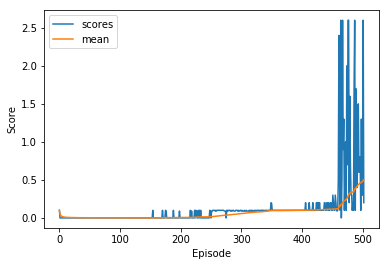

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
plt.plot(scores, label='scores')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.plot(running_mean, label='mean')
plt.legend()
fig.savefig('result.png')
plt.show()

## Next Steps:

Compare this method to Reinforce algorithm

Use prioritized experince replay for better convergence 